In [1]:
import sys
import pathlib
base_path = "C:/Users/marcel.zoll/Documents/repo/tfs_marzol/Marcel/pythonize"
sys.path.insert(0, base_path+"/Sklearning")

In [2]:
'''
simplistic example showing how to use the modules contained in sklearnext
'''


#import sys, os, pathlib
#sys.path.insert(0, str(pathlib.Path(os.getcwd()).parents[1] / 'python'))

#some basic imports
import sys, os, copy
import numpy as np
import datetime as dt
import pandas as pd

In [3]:
#=========================================================================
# construct a dataset with some observations and all kind of mixed lables
#=========================================================================

#--- define the sample size
nObs = 10000

#--- create a observation matrix
idx = np.array(list(range(nObs))) + 1000
c0 = np.array(np.random.choice(['A','B'], size=int(nObs*0.8)).tolist() + ['A']*int(nObs*0.2) )

c1_h = np.random.choice([12,13,14], size=nObs)
c1_d = np.random.choice([0,1], size=nObs)
c1_s = np.random.randint(60, size=nObs)

c1 = []
for i in range(nObs):
    c1.append( dt.datetime(2017,1,1,0,0,0) + dt.timedelta(days=int(c1_d[i]), hours=int(c1_h[i]), minutes=int(c1_s[i])) )

c2 = np.random.choice(['a','b','c'], size=nObs)
c3 = np.round(np.random.rand(nObs), 2)

X = pd.DataFrame({'Device': c0,
             'Time': c1,
             'Label':c2,
             'Cont':c3}, index = idx)

print(X.shape, X.columns)

#--- create a results vector
class xthelper():
    j = 0
    def __int__(self):
        pass
    def __call__(self, row):
        dev_dict = {'A':0.3, 'B':0.8}
        label_dict = {'a':0.8, 'b':0.6, 'c':0.7}
        prob =  ( 0.5 + 0.1*c1_d[self.j] - (c1_h[self.j]-12)*0.5 ) * label_dict[row['Label']] + (row['Cont']-0.5)/4
        prob = max(min(1.,prob), 0.)

        self.j+=1
        if row['Device'] == 'A':
            return int(prob>0.3)
        else:
            return int(prob>0.5)
    
y= X.apply(xthelper(), axis=1)

print(y.shape, "coverage %f" % (np.sum(y)/y.shape[0]))

#split up dataset into train and (held out)test sample
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(10000, 4) Index(['Cont', 'Device', 'Label', 'Time'], dtype='object')
(10000,) coverage 0.169300
(8000, 4) (8000,) (2000, 4) (2000,)


In [9]:
#======================
# PIPELINE ASSEMBLY
#======================
from sklearnext.Assembly import *
from sklearnext.Sklearning.GBDTreeLearner import *
from sklearnext.Sklearning.OneProbClassifier import *
from sklearnext.Learning.Learner import *
from sklearnext.Transformers.General import *

#assemble the pipeline by bits an pieces

#OneHot/Label encoding for feature 'Label'
tf0 = TransformerPipe([
        ('pagehistExtr', ColumnsSelect(['Label'])),
        ('labelEnc', LabelDummyTransformer())
    ])

#Extraction of Hour and Day-of-Month fromfeature  'Time'
tf1 = TransformerPipe([
        ('starttimeExtr', ColumnsSelect('Time')),
        ('hwdmyExtr', HourWeekdayDayMonthYearTransformer()),
        ('hwdselect', ColumnsSelect(['Time_hour', 'Time_day']))
    ])

#assemble a set of to use features
fu = FeatureUnion([
        ('tf0', tf0),
        ('tf1', tf1),
        ('tf2', ColumnsSelect('Cont')) # feature 'Cont' could have been wrapped into its own pipeline,
                                       # but no need to convolute as already in correct format
    ], n_jobs= 1)

#define a Classifier estimator; here one that is smarter as the average by growing additional trees
skl_c0 = GrowingGBClassifier(ntrees_start = 100,
            ntress_increment = 10,
            est_params = {'max_depth': 3,
                          'max_features': None}, #auto
            scoring = 'log_loss', #binary_roc_auc
            min_score_improvement = 1e-5,
            nrounds_noimp = 2,
            nrounds_stop = sys.maxsize,
            cv_test_frac = 0.2, 
            cv_n_splits = 3)
                      
#as we are interested in the probabilities rather than the absolute binary classification use this shim
skl_cc0 = OneProbClassifierWrapper(skl_c0, predictClass=1)

# as OneProbClassifier (and GrowingGBClassifier) are using the sklearn interface, make them pandas compatible
cc0 = SklearnerWrapper(skl_cc0)

#this is a complete pipeline, which uses all features except 'Device'
pred_pipe = Pipeline([
        ("fu",fu),
        ("cc0", cc0)
    ])

#make a categorical fork for the feature Device, which has two levels
cf = CategoryFork(pred_pipe,
                  'Device',
                  [('A'),('B')],
                  n_jobs=1 )

#define this by an alias
main_pipe = cf

In [11]:
#=============================
# Train, Verify and Quantisize the model
#=============================

#--- train the pipeline
main_pipe.fit(X_train, y_train)

#--- verify the model
from sklearnext.Metric import *
ClassifierOvertrainCheck(main_pipe, X_train, y_train, X_test, y_test)

#--- have a look at the most important features for each pipeline
fi_deep = cf.get_feature_importances_deep()
print(fi_deep)

fi = cf.get_feature_importances()
print(fi)

copy init
done
group done
fit
shapes  (4825, 6) (4825,)
resetting estimator to null-state
call from <sklearnext.Sklearning.GBDTreeLearner.GrowingGBClassifier object at 0x0000019491A64550>
round n_est meter
0 100 -0.008177
1 110 -0.006891
2 120 -0.005813
3 130 -0.004962
4 140 -0.004373
5 150 -0.003850
6 160 -0.003350
7 170 -0.003079
8 180 -0.002906
9 190 -0.002768
10 200 -0.002682
11 210 -0.002620
12 220 -0.002584
13 230 -0.002482
14 240 -0.002413
15 250 -0.002454
16 260 -0.002466
no improvement for 2 rounds
With 240 estimators:: TrainScore(cv-test): -0.002413 , TrainScore(all): -0.000412
shapes  (3175, 6) (3175,)
resetting estimator to null-state
call from <sklearnext.Sklearning.GBDTreeLearner.GrowingGBClassifier object at 0x00000194919F97F0>
round n_est meter
0 100 -0.007590
1 110 -0.007368
2 120 -0.007214
3 130 -0.007185
4 140 -0.007326
5 150 -0.007541
no improvement for 2 rounds
With 130 estimators:: TrainScore(cv-test): -0.007185 , TrainScore(all): -0.000678
RocAuc score :: train: 

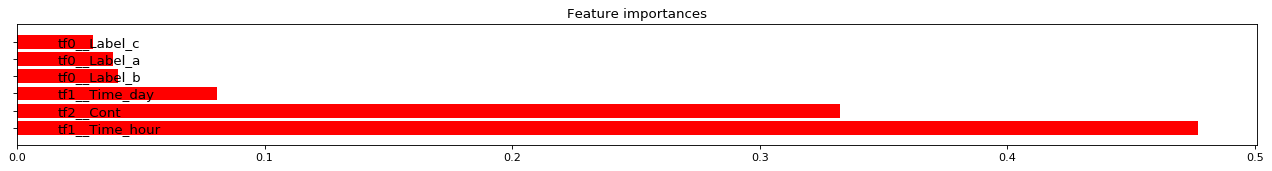

In [19]:
#--- plot the feature importances
from sklearnext.Visualization.viz import *
plot_FeatureImportances(main_pipe)

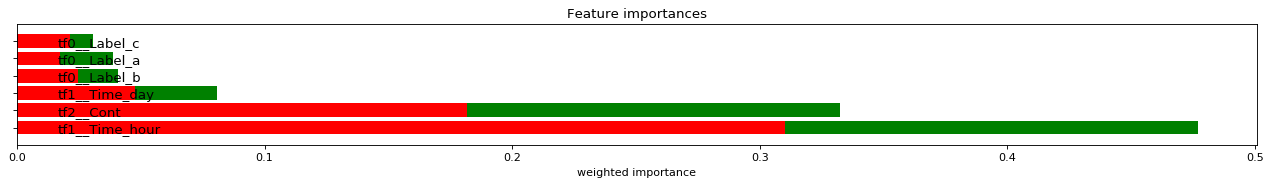

In [20]:
plot_CategoryFork_FeatureImportances(main_pipe, coverage_weighted=True)

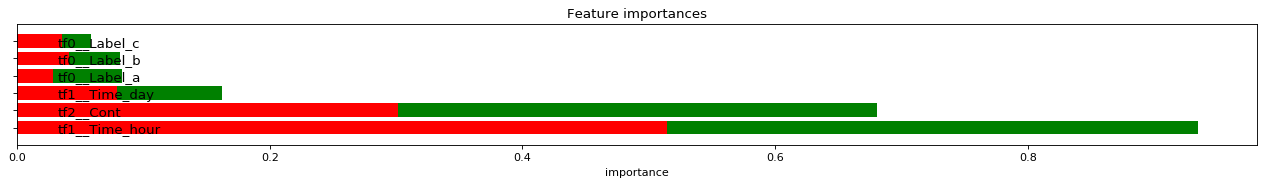

In [21]:
plot_CategoryFork_FeatureImportances(main_pipe, coverage_weighted=False)